This notebook contains python codes to run strontium isotope box model

In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

In [2]:
# Functions
# ---------
# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
    grad : float
          gradient of rSw  
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
    
    grad = np.diff(rsw)/np.diff(age)
    grad = np.append(grad, grad[-1])
   
    return rsw, grad

### Define time
This block of code creates arrays to run the simulation.

In [3]:
# Define array of time
# --------------------
tmin = 487      # ~ base of Ordovician in Ma (GTS2020)
tmax = 443      # ~ base of Silurian in Ma (GST2020)
nt = 100000     # number of steps
dt = (tmin - tmax)*1e6 / nt    # size of each step
time = np.linspace(0, (tmin-tmax)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and parameters
# -----------------------------
# Riverine flux (Jones and Jenkyns, 2001)
Jriv0 = 3.34e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio (Jones and Jenkyns, 2001)
Rriv0 = 0.7119
Rriv = np.ones(nt) * Rriv0

#Hydrothermal flux
Jh0 = 2e10
Jh = np.ones(nt)*1.05e10

# Hydrothermal isotopic ratio (Jones and Jenkyns, 2001)
Rh0 = 0.7033
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater and rate of change
Rsw = np.zeros(nt)
GradSr = np.zeros(nt)

# Reservoir size (Jones and Jenkyns, 2001)
N = np.ones(nt) * 1.24e17

### Constraining changes in hydrothermal activities using long-term sea-level change

In this model we hypothesize a role for hydrothermal activities in perturbing global Sr cycles during the Ordovician. To model changes in hydrothermal activities we used eustatic sea level curves, assuming the long-term changes in sea levels are mainly controlled by changes in ocean basin geometry, which in turn depends on the rate of sea floor spreading.

Sea level curves were taken from Haq and Schutter (2008), and recalibrated to Geologic Time Scale 2020 (Goldman et al., 2020).

In [5]:
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

array size = 100000


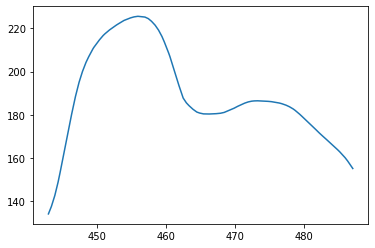

In [6]:
# resample data to fit our modeling array
from scipy import interpolate

f = interpolate.interp1d(ordoseaage, ordosealevel)

sealevel = f(age)
plt.plot(age, sealevel)
print('array size =',len(sealevel))

max  : 1.4536080670085052
min  : 0.8646907216494846
mean : 1.221990718759185


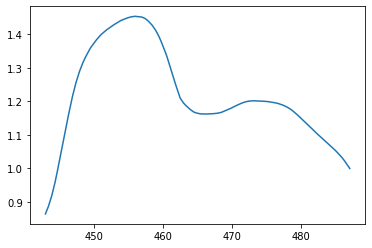

In [7]:
# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()
sl_norm_min = sealevel / sealevel[0]

plt.plot(age, sl_norm_min)
print('max  :', sl_norm_min.max())
print('min  :', sl_norm_min.min())
print('mean :', sl_norm_min.mean())

In [8]:
Jh_sl = sl_norm * Jh0

In [9]:
Rsw_sl = np.zeros(nt)
Rsw_sl, GradSr_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

# Final Figure

In [10]:
# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
chronoDf.head(7)

,label,abbr,mix,top,bottom,color,h
0,Hirnantian,Hir.,Hir.,443.07,445.21,#A6DBAB,2.14
1,Katian,Kat.,Katian,445.21,452.75,#99D69F,7.54
2,Sandbian,Sand.,Sand.,452.75,458.18,#8CD094,5.43
3,Darriwillian,Darr.,Darriwillian,458.18,469.42,#74C69C,11.24
4,Dapingian,Dap.,Dap.,469.42,471.26,#66C092,1.84
5,Floian,Flo.,Flo.,471.26,477.08,#41B087,5.82
6,Tremadocian,Tre.,Tremadocian,477.08,486.85,#33A97E,9.77


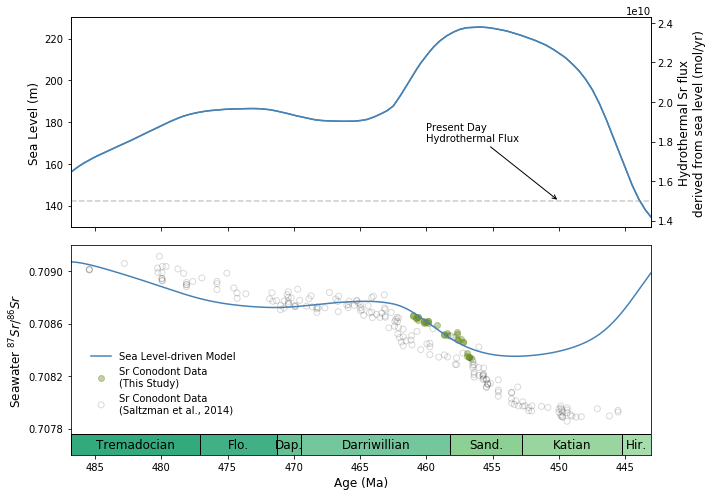

In [11]:
# Load sr measurement for comparison
SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
loess = pd.read_csv('../Data/LOESS2_0.75_Gradient.csv')
SrOrdo_2014 = pd.read_csv('../Data/OrdoSr20.csv')

#Make the Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)

ax1.plot(age, sealevel,  c='steelblue', label='Sea Level')
ax1.set_ylabel("Sea Level (m)", fontsize=12)
ax1.invert_xaxis()

ax1b = ax1.twinx()
ax1b.plot(age, Jh_sl, c='steelblue')
ax1b.axhline(y=1.5e10, ls='--', c='gray', alpha=0.4)
ax1b.set_ylabel('Hydrothermal Sr flux\nderived from sea level (mol/yr)', fontsize=12)
ax1b.annotate('Present Day\nHydrothermal Flux', xy=(450, 1.5e10), xytext=(460, 1.8e10),
            arrowprops=dict(arrowstyle='->'))


trans = ax2.get_xaxis_transform()
ax2.plot(age, Rsw_sl, c='steelblue', label="Sea Level-driven Model")
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['Age20'], SrOrdo_2014['Sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014)',
            alpha=0.15)
ax2.set_ylabel('Seawater $^{87}Sr/^{86}Sr$', fontsize=12)
ax2.set_xlabel('Age (Ma)', fontsize=12)
ax2.legend(loc='lower left', bbox_to_anchor=(0.02, 0.15), edgecolor='None')

for ind in chronoDf.index:
    ax2.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax2.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)
    
ax2.set_xlim(486.85, 443.07)
ax2.set_ylim(0.7076, 0.7092)
ax2.set_yticks(np.linspace(0.7078, 0.7090, 4))

plt.tight_layout()
plt.savefig('../Figures/PaperFigure.png')
plt.savefig('../Figures/PaperFigure.svg')
plt.show()

,Starting Age,Ending Age,Starting Flux,Ending Flux,Starting Ratio,Ending Ratio
0,487.0,473.0,1.636674e+10,1.966750e+10,0.709072,0.708733
1,473.0,466.0,1.966750e+10,1.902422e+10,0.708733,0.708762
2,466.0,456.0,1.902422e+10,2.379082e+10,0.708762,0.708387
3,456.0,443.0,2.379082e+10,1.415217e+10,0.708387,0.708992


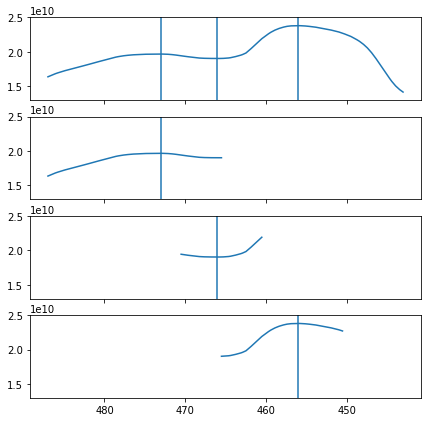

In [13]:
#Calculating Shifts in Trend

stage1_end = np.where(np.round(age)==465)[0][0]
stage1_range = Jh_sl[:stage1_end]
stage1_agerange = age[:stage1_end]
stage1_max = np.round(max(stage1_range))
stage1_maxindex = np.where(np.round(Jh_sl)==stage1_max)[0][0]
stage1_maxage = round(age[stage1_maxindex])

stage2_start = np.where(np.round(age)==470)[0][0]
stage2_end = np.where(np.round(age)==460)[0][0]
stage2_range = Jh_sl[stage2_start:stage2_end]
stage2_agerange = age[stage2_start:stage2_end]
stage2_min = round(min(stage2_range))
stage2_minindex = np.where(np.round(Jh_sl)==stage2_min)[0][0]
stage2_minage = round(age[stage2_minindex])

stage3_start = np.where(np.round(age)==465)[0][0]
stage3_end = np.where(np.round(age)==450)[0][0]
stage3_range = Jh_sl[stage3_start:stage3_end]
stage3_agerange = age[stage3_start:stage3_end]
stage3_max = round(max(stage3_range))
stage3_maxindex = np.where(np.round(Jh_sl)==stage3_max)[0][0]
stage3_maxage = round(age[stage3_maxindex])

#Table
starting_age = [tmin,stage1_maxage,stage2_minage,stage3_maxage]
ending_age = [stage1_maxage,stage2_minage,stage3_maxage,tmax]
starting_flux = (Jh_sl[0],Jh_sl[stage1_maxindex],Jh_sl[stage2_minindex],Jh_sl[stage3_maxindex])
ending_flux = (Jh_sl[stage1_maxindex],Jh_sl[stage2_minindex],Jh_sl[stage3_maxindex],Jh_sl[len(Jh_sl)-1])
starting_ratio = (Rsw_sl[0],Rsw_sl[stage1_maxindex],Rsw_sl[stage2_minindex],Rsw_sl[stage3_maxindex])
ending_ratio = (Rsw_sl[stage1_maxindex],Rsw_sl[stage2_minindex],Rsw_sl[stage3_maxindex],Rsw_sl[len(Rsw_sl)-1])


stages = pd.DataFrame({'Starting Age':starting_age,'Ending Age':ending_age,'Starting Flux':starting_flux,\
                      'Ending Flux':ending_flux,'Starting Ratio':starting_ratio,'Ending Ratio':ending_ratio})


#plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 7), sharex=True)

ax1.plot(age, Jh_sl)
ax1.axvline(x=stage1_maxage)
ax1.axvline(x=stage2_minage)
ax1.axvline(x=stage3_maxage)
ax1.invert_xaxis()
ax1.set_ylim(1.3e10, 2.5e10)

trans = ax2.get_xaxis_transform()
ax2.plot(stage1_agerange,stage1_range)
ax2.axvline(x=stage1_maxage)
ax2.set_ylim(1.3e10, 2.5e10)

trans = ax3.get_xaxis_transform()
ax3.plot(stage2_agerange,stage2_range)
ax3.axvline(x=stage2_minage)
ax3.set_ylim(1.3e10, 2.5e10)

trans = ax4.get_xaxis_transform()
ax4.plot(stage3_agerange,stage3_range)
ax4.axvline(x=stage3_maxage)
ax4.set_ylim(1.3e10, 2.5e10)

stages

# Alternative

Model Parameters based on Young et al (2009) Model, with a modified equation to calculate Hydrothermal flux $(Sr_{Hydrothermal})$ shown below:

$$Sr_{Hydrothermal} = \left(\frac{S(t)}{\overline{S}}\right)^{2.5} \times Sr_{hydrothermal}(t_{min})$$

Where:

$S(t)$ = Sea level at time $t$

$\overline{S}$ = Mean sea level from $t_{min}$ to $t_{max}$

In [ ]:
# Initial values and parameters
# -----------------------------
# Riverine flux (Jones and Jenkyns, 2001)
Jriv0 = 3e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio (Jones and Jenkyns, 2001)
Rriv0 = 0.7106
Rriv = np.ones(nt) * Rriv0

#Hydrothermal flux
Jh0 = 1.3e10
Jh = np.ones(nt)*1.05e10

# Hydrothermal isotopic ratio (Jones and Jenkyns, 2001)
Rh0 = 0.7037
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater and rate of change
Rsw = np.zeros(nt)
GradSr = np.zeros(nt)

# Reservoir size (Jones and Jenkyns, 2001)
N = np.ones(nt) * 1.9e17

# Scale Jh
Jh_sl = (sl_norm**2.5) * Jh0

# Run Model
Rsw_sl = np.zeros(nt)
Rsw_sl, GradSr_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

Rsw_slmin = np.zeros(nt)
Rsw_slmin, GradSr_slmin = run_sim(nt, dt, age, Jriv, Rriv, Rsw_slmin, Jh_sl, Rh-0.0007, N)

Rsw_slmax = np.zeros(nt)
Rsw_slmax, GradSr_slmin = run_sim(nt, dt, age, Jriv, Rriv, Rsw_slmax, Jh_sl, Rh+0.0007, N)

#Make the Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True)

ax1.plot(age, sealevel,  c='steelblue', label='Sea Level')
ax1.set_ylabel("Sea Level (m)", fontsize=12)
ax1.invert_xaxis()

ax1b = ax1.twinx()
ax1b.plot(age, Jh_sl, ls='--', c='gray')
ax1b.axhline(y=1.5e10, ls='--', c='gray', alpha=0.4)
ax1b.set_ylabel('Hydrothermal Sr Flux (mol/yr)', fontsize=12)
ax1b.annotate('Present Day\nHydrothermal Flux', xy=(450, 1.5e10), xytext=(455, 1e10),
            arrowprops=dict(arrowstyle='->'))

ax1b.annotate('Modeled\nHydrothermal Flux', xy=(age[5000], Jh_sl[5000]), xytext=(483, 0.6e10),
            arrowprops=dict(arrowstyle='->'))



trans = ax2.get_xaxis_transform()
ax2.plot(age, Rsw_sl, c='steelblue', label="Sea level-driven Model")
ax2.plot(age, Rsw_slmin, c='steelblue',alpha=0.1)
ax2.plot(age, Rsw_slmax, c='steelblue',alpha=0.1)
ax2.fill_between(age, Rsw_slmax, Rsw_slmin, color='steelblue', alpha=0.1)
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['Age20'], SrOrdo_2014['Sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014)',
            alpha=0.15)
ax2.set_ylabel('Seawater $^{87}Sr/^{86}Sr$', fontsize=12)
ax2.set_xlabel('Age (Ma)', fontsize=12)
ax2.legend(loc='lower left', bbox_to_anchor=(0.02, 0.15), edgecolor='None')

for ind in chronoDf.index:
    ax2.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax2.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)
    
ax2.set_xlim(486.85, 443.07)
ax2.set_ylim(0.7075, 0.7093)
ax2.set_yticks(np.linspace(0.7078, 0.7090, 4))

plt.tight_layout()
plt.savefig('../Figures/PaperFigure_alt.png')
plt.savefig('../Figures/PaperFigure_alt.pdf')
plt.show()